# DORIS Doppler Processing – Clean Implementation

This notebook contains a clean and structured implementation of the DORIS Doppler processing workflow.  
It is based on prior experimental code and has been refactored to improve readability, modularity, and maintainability.

## Purpose

The goal of this notebook is to:
- Load and parse DORIS measurement data (RINEX or raw format)
- Apply necessary physical and instrumental corrections (e.g. ionospheric, tropospheric, relativistic)
- Compute Doppler residuals between observed and computed values
- Visualize results and prepare data for further orbit adjustment or parameter estimation

This cleaned version focuses solely on the essential steps required for reproducible, high-accuracy processing.

> This notebook is part of the internal development for precise orbit determination using DORIS data.


In [1]:
#Section 1 - Imports

#imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

#DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere import gmf, gpt3, tropo

In [2]:
# Section 2.1 – Define File Paths
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
gpt3_file = join(data_path, "gpt3_5.grd")

In [3]:
# Section 2.2 - Load Orbit Data + Initialize Interpolator 
sp3 = sp3c.Sp3(dsp3)
satid = sp3.sat_ids[0]
sp3_data = sp3.get_satellite(satid, True)
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

In [4]:
#Section 2.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# DIOB DORIS beacon
diob = 'D31'

# approx. DIOB coordinates, see https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=np.array([4595212.468, 2039473.691, 3912617.891])

In [5]:
#Section 2.4 - Convert beacon cartesian coordinates to geodetic
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

In [6]:
#Section 3 - helper functions -- move to DSO modules**

#calculate azimuth, elevation 
def azele(rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

#Get indices for every pass
def compute_pass_indices(times, threshold_sec=600):
    pass_indices = []
    current_pass = 0
    last_time = times[0]

    for t in times:
        delta_t = (t - last_time).total_seconds()
        if delta_t > threshold_sec:
            current_pass += 1  # New pass
        pass_indices.append(current_pass)
        last_time = t

    return pass_indices

In [7]:
# Section 4.1 – Compute nominal frequencies for beacon

def beacon_info(rnx, beacon_num):
    freqshift = None
    for stainf in rnx.beacons:
        if stainf['num'] == beacon_num:
            freqshift = stainf['freqshift']
            break
    if freqshift is None:
        raise RuntimeError(f"Failed finding beacon info for {beacon_num} in rinex file {rnx.filename}")
    
    # Βeacon shift factor (k), used to compute nominal frequencies   
    return beacon_nominal_frequency(freqshift)

In [8]:
# Section 4.2 – Extract and fit raw frequency offsets from RINEX

t_all = []; F_all = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            t_all.append(at2pt(t2))
            #get frequency offset from block
            F = data['F']['value']
            F_all.append(F)

# convert time to seconds
t0 = t_all[0]
t_seconds = [(ti - t0).total_seconds() for ti in t_all]

# Perform polynomial fit (4th degree)
smoothing_coeffs = np.polyfit(t_seconds, F_all, 4)
F_smooth_fn = np.poly1d(smoothing_coeffs)

In [9]:
# Section 5.1 – Initialize storage and previous state variables for preprocessing

# initially, no previous phase observation ...
t1=None
dT2 = None
satx_prev = saty_prev = satz_prev = None

# store results here 
t = []               # observation time
res2 = []            # Doppler residuals
raw_obs = []         # raw data for LSQ estimation
el_valid = []        # elevation angles
dT_list = []         # tropospheric delays

In [10]:
# Section 5.2 – Preprocess Doppler observations (filter valid ones for LS)

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == diob:
            feN2, feN4 = beacon_info(rnx, beacon)
            sf = (feN2 / feN4)**2
            # Reference frequency used for L3 combination and Doppler computation
            frN = (feN2**2 - feN4**2) / (feN2 - feN4)
            feN3 = (sf * feN2 - math.sqrt(sf) * feN4) / (sf - 1)
            
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # Satellite position at signal emission time
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            rsat2 = np.array([satx, saty, satz])

            # Elevation and tropospheric delay
            _, _, el = azele(rsat2, diob_xyz)
            dT = tropo.tropo_delay(diob_xyz, t2, el, gpt3_file)

            # Phase measurements and L3 combination
            L2_1 = data['L1']['value']
            L2_2 = data['L2']['value']
            L3 = (sf * L2_1 - math.sqrt(sf) * L2_2) / (sf - 1)

            # Smoothed frequency offset at time t2
            t2_sec = (at2pt(t2) - t0).total_seconds()
            F_smoothed = F_smooth_fn(t2_sec)
            frT = frN * (1 + F_smoothed * 1e-11)

            # if we have a previous measurement, within 10 sec ...
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                # observed range-rate
                orr = (((L3 - L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) + frT - frN) * (299792458.0 / feN3)
                
                t.append(at2pt(t2))
                el_valid.append(np.degrees(el))
                dT_list.append(dT)
                raw_obs.append({
                    'rsat1': np.array([satx_prev, saty_prev, satz_prev]),
                    'rsat2': rsat2,
                    'dt': (float((t2-t1).total_nanoseconds()) * 1e-9),
                    'v_obs': orr,
                    'dT': (dT2 - dT) if dT2 is not None else 0.0,
                })
                
        # prepare for next measurement
            dT2 = dT
            t1 = t2
            L1 = L3
            satx_prev, saty_prev, satz_prev = satx, saty, satz
print(f"Number of Doppler observations extracted: {len(raw_obs)}")

Number of Doppler observations extracted: 1109


In [11]:
# Section 5.3 – Summary of residual extraction

In [13]:
# Section 5.4 – Assign pass indices to observations

pass_indices = compute_pass_indices(t, threshold_sec=600)
Np = max(pass_indices) + 1
print(f"Total passes: {Np}")

Total passes: 8


In [14]:
# Section 6.1 – Initialize Least Squares estimation variables

# Initial guess: [x, y, z, Δf, ΔT_pass1, ΔT_pass2, ..., ΔT_passN]
x0 = np.zeros(4 + Np)         # parameter vector
x0[0:3] = diob_xyz            # start with nominal beacon position

m = len(raw_obs)              # number of valid Doppler observations
J = np.zeros((m, 4 + Np))     # Jacobian matrix (design matrix)
dl = np.zeros(m)              # residual vector (observed - modeled)

LS_ITERATIONS = 3             # number of least squares iterations

In [19]:
#Section 6.2 – Least Squares Solution

for ls_iteration in range(LS_ITERATIONS):
    for i, obs in enumerate(raw_obs):
        rsat1 = obs['rsat1']
        rsat2 = obs['rsat2']
        dt = obs['dt']
        v_obs = obs['v_obs']
        dT = obs['dT']

        # Current parameter estimates
        r_beacon = x0[0:3]               # beacon position estimate
        delta_f = x0[3]                  # common frequency bias
        pass_id = pass_indices[i]
        delta_T = x0[4 + pass_id]        # time bias for current pass

        # Computed range-rate
        r1 = np.linalg.norm(rsat1 - r_beacon)
        r2 = np.linalg.norm(rsat2 - r_beacon)
        v_comp = (r2 - r1) / dt
        
        # Observation Equation (residuals)
        dl[i] = v_obs + obs['dT']/dt - v_comp - delta_f - delta_T/dt
        
        if abs(dl[i]) > 10.0:
            #print(f"Skipping obs {i} due to large residual: {dl[i]:+.3f} m/s")
            dl[i] = 0.0
            J[i, :] = 0.0
            continue

        # Jacobian Matrix 
        J[i, 0:3] = (r_beacon - rsat2) / (r2 * dt) - (r_beacon - rsat1) / (r1 * dt)
        J[i, 3] = +1.0

        pass_id = pass_indices[i]
        J[i, 4 + pass_id] = 1.0 / dt

    # least squares solution
    dx, *_ = np.linalg.lstsq(J, dl, rcond=None)
    x0 += dx

    # a-posteriori σφάλμα μονάδας βάρους
    sigma = np.sqrt(np.sum(dl**2) / (m - (4 + Np)))


In [27]:
# Section - Hasrsh outlier detection (better plots!)
def filter_residuals(t, dl, sigma):
    tclean = []
    dlclean = []
    for ti, ri in zip(t, dl):
        if abs(ri) <= 3.*sigma:
            tclean.append(ti)
            dlclean.append(ri)
    print(f"Note, marking {len(t)-len(tclean)}/{len(t)} of observations as outliers.")
    return tclean, dlclean

In [28]:
# Section 6.3 – Final parameter estimates and comparison to initial guess

final_xyz = x0[0:3]
initial_xyz = diob_xyz
delta_xyz = final_xyz - initial_xyz
delta_norm = np.linalg.norm(delta_xyz)

print("\n[RESULT] Beacon estimated position vs initial (XYZ):")
print(f"  X = {final_xyz[0]:.3f} m   | X_init = {initial_xyz[0]:.3f} m   | ΔX = {delta_xyz[0]:+.3f} m")
print(f"  Y = {final_xyz[1]:.3f} m   | Y_init = {initial_xyz[1]:.3f} m   | ΔY = {delta_xyz[1]:+.3f} m")
print(f"  Z = {final_xyz[2]:.3f} m   | Z_init = {initial_xyz[2]:.3f} m   | ΔZ = {delta_xyz[2]:+.3f} m")

print(f"\n[RESULT] Total position error (‖Δr‖): {delta_norm:.3f} m")

print(f"\n[RESULT] Estimated frequency bias Δf:")
print(f"  Δf = {x0[3]:+.6f} m/s")

print(f"\n[RESULT] Estimated time biases per pass (ΔT_pass / dt):")
for i, dtp in enumerate(x0[4:]):
    print(f"  Pass {i+1}: ΔT_pass = {dtp:+.6f} m/s")



[RESULT] Beacon estimated position vs initial (XYZ):
  X = 4595215.733 m   | X_init = 4595212.468 m   | ΔX = +3.265 m
  Y = 2039469.984 m   | Y_init = 2039473.691 m   | ΔY = -3.707 m
  Z = 3912616.568 m   | Z_init = 3912617.891 m   | ΔZ = -1.323 m

[RESULT] Total position error (‖Δr‖): 5.113 m

[RESULT] Estimated frequency bias Δf:
  Δf = +2.663277 m/s

[RESULT] Estimated time biases per pass (ΔT_pass / dt):
  Pass 1: ΔT_pass = -0.107117 m/s
  Pass 2: ΔT_pass = -0.020700 m/s
  Pass 3: ΔT_pass = -0.009436 m/s
  Pass 4: ΔT_pass = -0.026797 m/s
  Pass 5: ΔT_pass = -0.055630 m/s
  Pass 6: ΔT_pass = -0.019306 m/s
  Pass 7: ΔT_pass = +0.021598 m/s
  Pass 8: ΔT_pass = +0.030578 m/s


Note, marking 4/1109 of observations


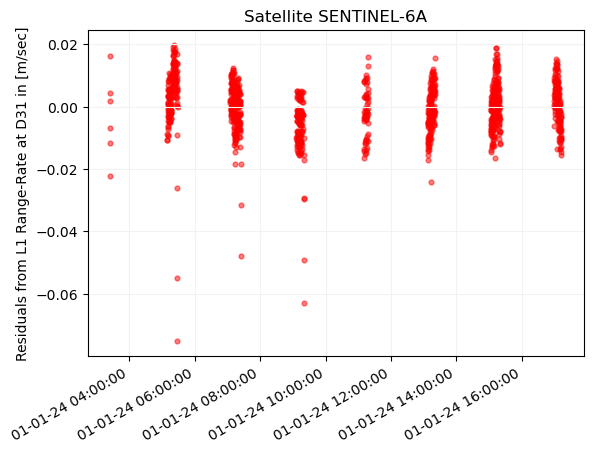

In [29]:
# Section 7.1 - Residual plot
# plt.scatter([at2pt(ti) for ti in t], dl, alpha=0.5, s=12, c='red')
plt.scatter(*filter_residuals([at2pt(ti) for ti in t], dl, sigma), alpha=0.5, s=12, c='red')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {diob} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

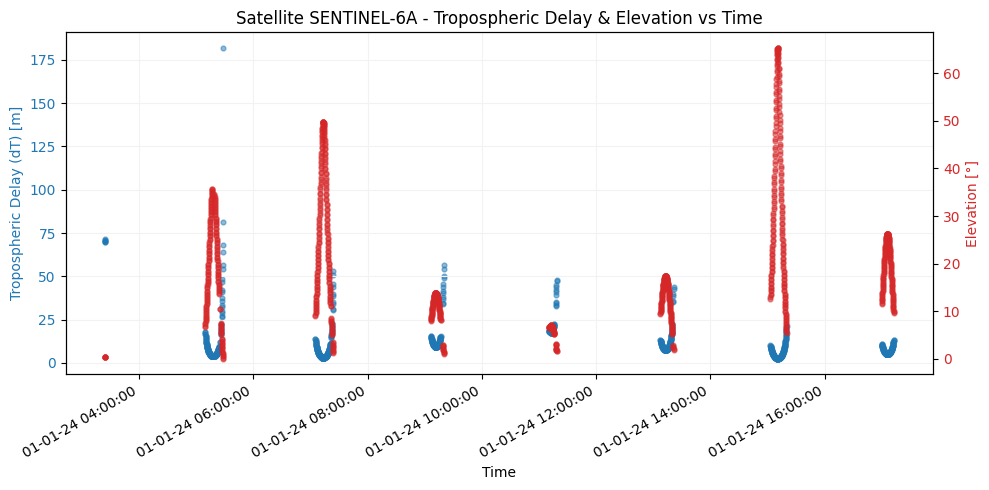

In [18]:
#Section 7.1 - Tropospheric Delay vs Elevation vs Time

# ---- Combined Scatter Plot ----
fig, ax1 = plt.subplots(figsize=(10, 5))

# First Axis: Tropospheric Delay (dT)
color1 = 'tab:blue'
ax1.set_xlabel("Time")
ax1.set_ylabel("Tropospheric Delay (dT) [m]", color=color1)
ax1.scatter(t, dT_list, alpha=0.5, s=12, color=color1, label="dT")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(color='0.95')

# Second Axis: Elevation
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Elevation [°]", color=color2)
ax2.scatter(t, el_valid, alpha=0.5, s=12, color=color2, label="Elevation")
ax2.tick_params(axis='y', labelcolor=color2)

# Format time axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
fig.autofmt_xdate()

plt.title(f"Satellite {rnx.sat_name} - Tropospheric Delay & Elevation vs Time")
plt.tight_layout()
plt.show()



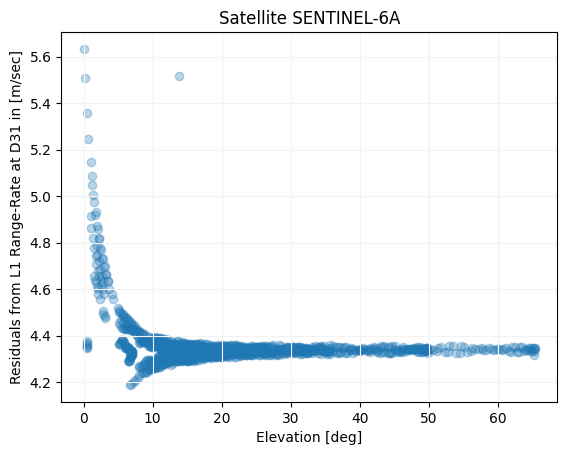

In [19]:
#Section 7.2 - Correlation between Residuals and Elevation

t1=None
els = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            satx, saty, satz, _, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp, None)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                if abs(orr - crr) > 100.:
                    pass
                else:
                    res.append(orr - crr)
                    els.append(np.degrees(el))
            r1 = r2
            t1 = t2
            L1 = L2

plt.scatter(els, res, alpha=0.3, marker='o')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.xlabel("Elevation [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()

In [20]:
# Section 7.4 – Observed range rate (v_obs) over time **possible addition